In [1]:
# !echo $PATH
from osgeo import gdal
# !conda activate ISCE2

In [ ]:
# !pip install matplotlib
# ds = gdal.Open('S1A_IW_SLC__1SDV_20210709T001159_20210709T001226_038693_0490E6_1961_split_Orb_Stack_deb_ifg_dinsar_flt.tif', gdal.GA_ReadOnly)

In [2]:
from shutil import copyfile, move # Utilities for copying and moving files
from osgeo import gdal, osr            # GDAL support for reading virtual files
import os                         # To create and remove directories
import matplotlib.pyplot as plt   # For plotting
import numpy as np                # Matrix calculations

def plotcomplexdata(GDALfilename,
                    title=None, aspect=1,
                    datamin=None, datamax=None,
                    interpolation='nearest',
                    draw_colorbar=None, colorbar_orientation="horizontal"):
    
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    slc = ds.GetRasterBand(1).ReadAsArray()
    print(slc.shape)
    transform = ds.GetGeoTransform()
    ds = None
    
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+slc.shape[1]*deltax
    lasty = firsty+slc.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])
    print(xmin,xmax,ymin,ymax)
    # put all zero values to nan and do not plot nan
    try:
        slc[slc==0]=np.nan
    except:
        pass
    
    fig = plt.figure(figsize=(18*2, 16*2))
    ax = fig.add_subplot(1,2,1)
    cax1=ax.imshow(np.abs(slc), vmin = datamin, vmax=datamax,
                   cmap='gray', extent=[xmin,xmax,ymin,ymax],
                   interpolation=interpolation)
    ax.set_title(title + " (amplitude)")
    if draw_colorbar is not None:
        cbar1 = fig.colorbar(cax1,orientation=colorbar_orientation)
    ax.set_aspect(aspect)

    ax = fig.add_subplot(1,2,2)
    cax2 =ax.imshow(np.angle(slc), cmap='rainbow',
                    vmin=-np.pi, vmax=np.pi,
                    extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title + " (phase [rad])")
    if draw_colorbar is not None:
        cbar2 = fig.colorbar(cax2, orientation=colorbar_orientation)
    ax.set_aspect(aspect)
    plt.show()
    
    # clearing the data
    slc = None
    

def plotdata(GDALfilename, band=1,
             title=None,colormap='gray',
             aspect=1, background=None,
             datamin=None, datamax=None,
             interpolation='nearest',
             nodata = None,
             draw_colorbar=True, colorbar_orientation="horizontal"):
    
    # Read the data into an array
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    data = ds.GetRasterBand(band).ReadAsArray()
    print(data.max(), data[data!=0].min(), data.mean(), data.shape)
    transform = ds.GetGeoTransform()
    ds = None
    
    try:
        if nodata is not None:
            data[data == nodata] = np.nan
    except:
        pass
        
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+data.shape[1]*deltax
    lasty = firsty+data.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    print(xmin,xmax,ymin,ymax)
    # put all zero values to nan and do not plot nan
    if background is None:
        try:
            data[data==0]=np.nan
        except:
            pass
    
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(111)
    cax = ax.imshow(data, vmin = datamin, vmax=datamax,
                    cmap=colormap, extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title)
    if draw_colorbar is not None:
        cbar = fig.colorbar(cax,orientation=colorbar_orientation, shrink=.4, pad=.05, aspect=10)
    ax.set_aspect(aspect)    
    plt.show()
    
    # clearing the data
    data = None

In [3]:
# config
GDAL_DATA_TYPE = gdal.GDT_Float64 
GEOTIFF_DRIVER_NAME = "GTiff"
NO_DATA = -32767
SPATIAL_REFERENCE_SYSTEM_WKID = 32767

def create_raster(output_path,
                  columns,
                  rows,
                  nband = 1,
                  gdal_data_type = GDAL_DATA_TYPE,
                  driver = GEOTIFF_DRIVER_NAME):

    driver = gdal.GetDriverByName(driver)

    output_raster = driver.Create(output_path, int(columns), int(rows), nband, eType = gdal_data_type)    
    return output_raster

def numpy_array_to_raster(output_path,
                          numpy_array,
                          proj,
                          trans,
                          nband = 1,
                          no_data = NO_DATA,
                          gdal_data_type = GDAL_DATA_TYPE,
                          spatial_reference_system_wkid = SPATIAL_REFERENCE_SYSTEM_WKID,
                          driver = GEOTIFF_DRIVER_NAME):


    rows, columns = numpy_array.shape
    output_raster = create_raster(output_path, int(columns), int(rows), nband, gdal_data_type) 
    geotransform = trans
    print(geotransform)

    spatial_reference = osr.SpatialReference()
    spatial_reference.ImportFromWkt(proj)
    # spatial_reference.ImportFromProj4('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
    output_raster.SetProjection(spatial_reference.ExportToWkt())
    output_raster.SetGeoTransform(geotransform)
    output_band = output_raster.GetRasterBand(1)
    output_band.SetNoDataValue(no_data)
    output_band.WriteArray(numpy_array)          
    output_band.FlushCache()
    print(output_raster.GetProjection())
    
    return  output_raster

In [4]:
def plotstackcomplexdata(GDALfilename_wildcard,
                         title=None, aspect=1,
                         datamin=None, datamax=None,
                         interpolation='nearest',
                         draw_colorbar=True, colorbar_orientation="horizontal"):
    # get a list of all files matching the filename wildcard criteria
    GDALfilenames = glob.glob(GDALfilename_wildcard)
    print(GDALfilenames)
    # initialize empty numpy array
    data = None
    for GDALfilename in GDALfilenames:
        ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
        data_temp = ds.GetRasterBand(1).ReadAsArray()
        ds = None
        
        if data is None:
            data = data_temp
        else:
            data = np.vstack((data,data_temp))

    # put all zero values to nan and do not plot nan
    try:
        data[data==0]=np.nan
    except:
        pass              
            
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(1,2,1)
    cax1=ax.imshow(np.abs(data), vmin=datamin, vmax=datamax,
                   cmap='gray', interpolation='nearest')
    ax.set_title(title + " (amplitude)")
    if draw_colorbar is not None:
        cbar1 = fig.colorbar(cax1,orientation=colorbar_orientation)
    ax.set_aspect(aspect)

    ax = fig.add_subplot(1,2,2)
    cax2 =ax.imshow(np.angle(data), cmap='rainbow',
                            interpolation='nearest')
    ax.set_title(title + " (phase [rad])")
    if draw_colorbar is not None:
        cbar2 = fig.colorbar(cax2,orientation=colorbar_orientation)
    ax.set_aspect(aspect)
    plt.show() 
    
    # clearing the data
    data = None

In [5]:
%cd /DATA/glacier-vel/jul_18_19pair
# feb_pair3
# jan_pair2
# %cd ../dinsar/inf1
# %cd /home/ayush12gupta/Desktop/ugp/exp2
# !ls fine_offsets/IW2

/DATA/glacier-vel/jul_18_19pair


In [16]:
!ls merged/topog
# !pwd ../jan_pair1/

ls: cannot access 'merged/topog': No such file or directory


In [6]:
# plotcomplexdata('reference/overlaps/IW3/burst_bot_01_02.slc.vrt',
#                 title='bot_01_02 (from Burst 2)',
#                 aspect=10, datamin=0, datamax=200)
# plotcomplexdata('reference/overlaps/IW3/burst_top_01_02.slc.vrt',
#                 title='top_01_02 (from Burst 1)',
#                 aspect=10, datamin=0, datamax=200)
# plotcomplexdata('reference/IW3/burst_01.slc.vrt',
#                 title='Burst 1',
#                 aspect=10, datamin=0, datamax=200)
# plotcomplexdata('reference/IW3/burst_02.slc.vrt',
#                 title='Burst 2', aspect=10,
#                 datamin=0,datamax=200,
#                 draw_colorbar=True,
#                 colorbar_orientation="horizontal")
# from osgeo import gdal
# ds = gdal.Open('fine_interferogram/IW3/burst_01.3alks_7rlks.int.vrt', gdal.GA_ReadOnly)
# slc = ds.GetRasterBand(1).ReadAsArray()
# slc.shape
plotdata('merged/z.rdr', band=1,
         title='IW3: Height of Burst 1 [meter]',
         colormap='terrain')
plotdata('merged/los.rdr', band=1,
         title='IW3: Incidence angle of Burst 1 [degrees]',
         colormap='jet')
plotdata('merged/los.rdr', band=2,
         title='IW3: Azimuth angle of Burst 1 [degrees]',
         colormap='jet')

ERROR 4: merged/z.rdr: No such file or directory


AttributeError: 'NoneType' object has no attribute 'GetRasterBand'

In [14]:
import cv2
im = np.dstack([inter, inter, inter])
im = im*255.
cv2.imwrite('../interpmask.png', im)

True

In [2]:
# import numpy as np
# cor = np.fromfile('ESD/overlap_IW3_01.5alks_15rlks.cor', dtype=np.float32).reshape(-1, )
# intf = (cor>0.75).sum()
# cor.mean()
!ls

coarse_coreg				    insar.log
coarse_interferogram			    isce.log
coarse_offsets				    merged
demLat_N31_N33_Lon_E075_E078.dem	    offset1.mat
demLat_N31_N33_Lon_E075_E078.dem.vrt	    offset.mat
demLat_N31_N33_Lon_E075_E078.dem.wgs84	    PICKLE
demLat_N31_N33_Lon_E075_E078.dem.wgs84.vrt  reference
demLat_N31_N33_Lon_E075_E078.dem.wgs84.xml  reference.xml
demLat_N31_N33_Lon_E075_E078.dem.xml	    secondary
demtest.tif				    secondary.xml
denseampcor.log				    topsApp.py
ESD					    topsApp.xml
fine_coreg				    topsinsar.log
fine_interferogram			    topsProc.xml
fine_offsets				    window_location.tif
geom_reference


In [7]:
filename = 'merged/reference.slc.full'
import shutil
# shutil.copy(filename, 'tmp.slc.full')
ds = gdal.Open(filename, gdal.GA_ReadOnly)
c, r = ds.RasterXSize, ds.RasterYSize
arr = ds.GetRasterBand(1).ReadAsArray()
ds = None

In [82]:
filename = 'merged/secondary.slc.full'
import shutil
# shutil.copy(filename, 'tmp.slc.full')
ds = gdal.Open(filename, gdal.GA_ReadOnly)
c, r = ds.RasterXSize, ds.RasterYSize
arr2 = ds.GetRasterBand(1).ReadAsArray()
ds = None

In [16]:
angle = np.angle(arr)
mc, mr = 17, 3
mlk = np.zeros((r//mr,c//mc))
# tmp = np.zero
for j in range(0,c-mc-2,mc):
    for i in range(0,r-mr-2,mr):
        mlk[i//mr,j//mc] = abs(arr[i:i+mc,j:j+mr]).mean()

In [84]:
# resamp2 = arr2[100:5100,100:5100]
del arr2

In [179]:
import cv2
# resamp = arr[100:5100,100:5100]
chipsz = 128
hmp = np.zeros((5000-chipsz,5000-chipsz))
x = np.random.randint((chipsz/2), 5000-(chipsz/2))
y = np.random.randint((chipsz/2), 5000-(chipsz/2))
chip = resamp[int(x-chipsz/2):int(x+chipsz/2),int(y-chipsz/2):int(y+chipsz/2)]

# for i in range(hmp.shape[0]):
#     for j in range(hmp.shape[1]):
        

In [60]:
def noisy(noise_typ,image, val=None):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + val*gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy

In [187]:
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR','cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
mth = cv2.matchTemplate(np.float32(abs(resamp2)),np.float32(noisy('speckle', abs(chip),10000)),cv2.TM_CCORR_NORMED)

In [19]:
print(x-chipsz/2,x+chipsz/2,y-chipsz/2,y+chipsz/2)

4287.0 4543.0 19.0 275.0


In [188]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(mth)
max_cent = np.add(max_loc,(chipsz/2,chipsz/2))
print(max_cent, [y, x])

[ 270. 4466.] [271, 4465]


In [168]:
# (mth>0.7).sum()
mth[y,x]
# mth

0.3315268

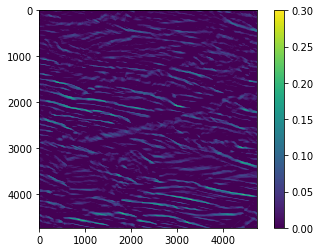

In [110]:
plt.imshow(mth, cmap='viridis', vmin=0, vmax=0.3)
plt.colorbar()
plt.show()

0.9999998

In [21]:
mc, mr = 17, 3
mlk_angl = np.zeros((r//mr,c//mc))
# tmp = np.zero
for j in range(0,c-mc-2,mc):
    for i in range(0,r-mr-2,mr):
        mlk_angl[i//mr,j//mc] = angle[i:i+mc,j:j+mr].mean()

In [17]:
del arr

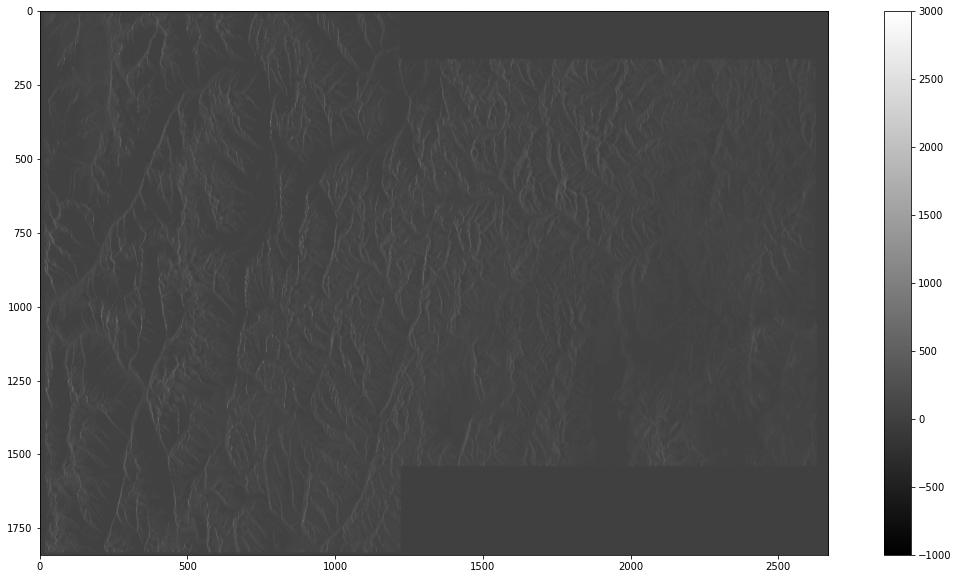

In [10]:
fig = plt.figure(figsize=(20,10))
plt.imshow(mlk, cmap='gray', vmin=-1000, vmax=3000)
plt.colorbar()

In [37]:
img = angle[500:2000,500:2000]
cv2_unwrap_img = np.copy(img)

# Phase unwrapping with OpenCV #
# create params
params = cv2.phase_unwrapping_HistogramPhaseUnwrapping_Params()
params.height = img.shape[0]
params.width = img.shape[1]
print('params.height: %i' % params.height)
print('params.width: %i' % params.width)
print('params.histThresh: %f' % params.histThresh)
print('params.nbrOfLargeBins: %i' % params.nbrOfLargeBins)
print('params.nbrOfSmallBins: %i' % params.nbrOfSmallBins)

# create histogram unwrapping instance
unwrapping_instance = cv2.phase_unwrapping_HistogramPhaseUnwrapping()
unwrapping_instance.create(params)

AttributeError: module 'cv2' has no attribute 'phase_unwrapping_HistogramPhaseUnwrapping_Params'

In [36]:
cv2.__version__

'4.5.5'

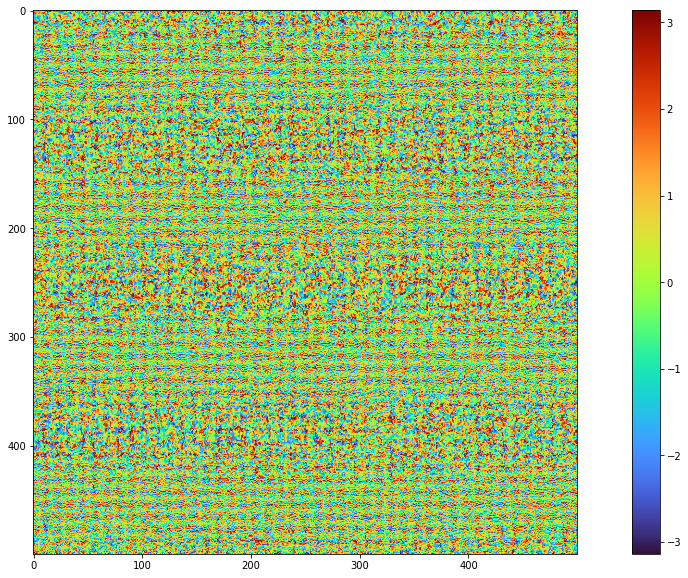

In [31]:
fig = plt.figure(figsize=(20,10))
plt.imshow(angle[500:1000,500:1000], cmap='turbo')
plt.colorbar()

KeyboardInterrupt: 

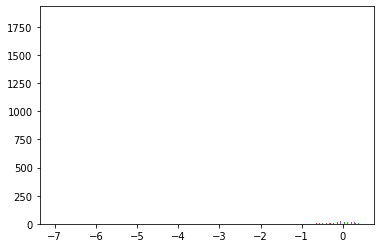

In [26]:
# data = dr[unw!=0].copy()
# print(data.shape, data.min(), data.max())

plt.hist(mlk_angl, bins=1000, range=[-7,0.4])
plt.show()

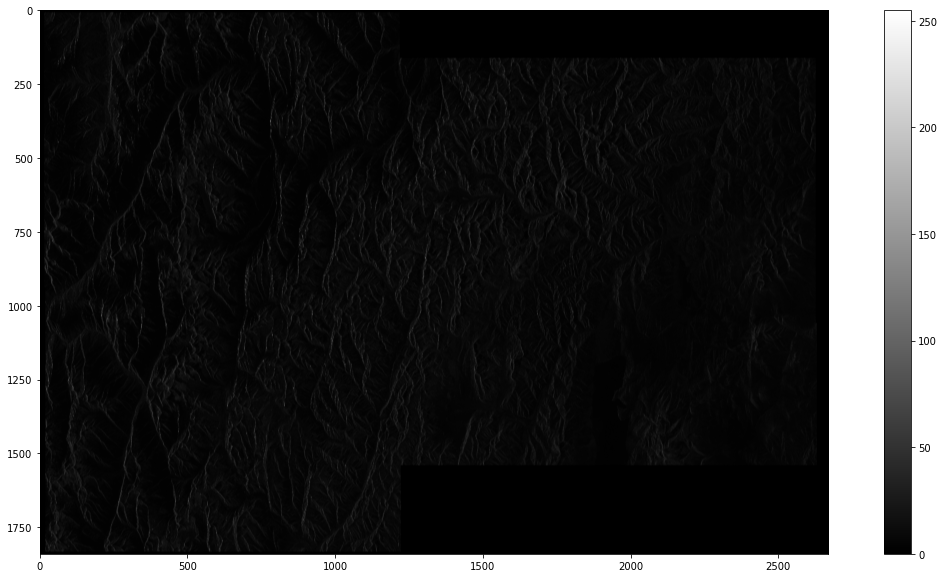

In [13]:
fig = plt.figure(figsize=(20,10))
plt.imshow(tmp, cmap='gray')
plt.colorbar()

In [ ]:
ds = None

7.5599017 -999999.0 -1033.0806 (1495, 21533)
0.0 21533.0 0.0 1495.0


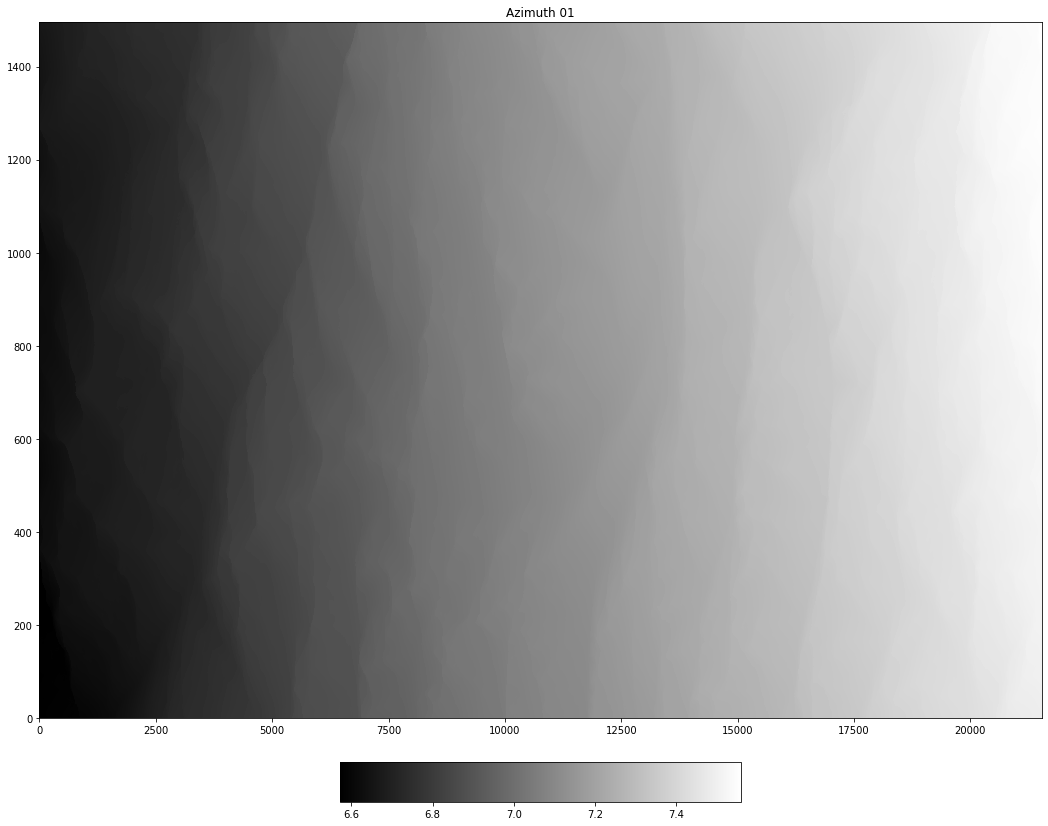

ERROR 4: fine_offsets/IW3/range_01.off.vrt: No such file or directory
gdalinfo failed - unable to open 'fine_offsets/IW3/range_01.off.vrt'.


In [7]:
plotdata('fine_offsets/IW1/range_04.off.vrt', band=1,
         title='Azimuth 01', colormap='gray', aspect=10,
         nodata=-999999.)
!gdalinfo -stats fine_offsets/IW3/range_01.off.vrt

In [ ]:
import plotly.express as px
data = f['Dx']
fig = px.imshow(data, color_continuous_scale='rainbow', color_continuous_midpoint=0)#["red", "green", "blue"])
# fig.title('Dx', fontsize=20)
fig.show()

# f['Dy'][f['Dy']<0].max()
# !pwd
# !gdalinfo demtest.tif

import plotly.express as px
data = f['InterpMask']
fig = px.imshow(data, color_continuous_scale='rainbow')#["red", "green", "blue"])
fig.show()
import plotly.express as px
data = f['Dy']
fig = px.imshow(data, color_continuous_scale='rainbow', color_continuous_midpoint=0)#["red", "green", "blue"])
fig.show()

In [8]:
dfrom osgeo import osr, gdal
ds = gdal.Open('demroi_x.tif')
#         ds = gdal.Open(grid_location)
tran = ds.GetGeoTransform()
proj = ds.GetProjection()
srs = ds.GetSpatialRef()
# print(grid_location, srs)
band = ds.GetRasterBand(1)
# nodata = band.GetNoDataValue()
xGrid = band.ReadAsArray()
xGrid.shape


(2869, 3283)

In [7]:
import numpy as np
np.array(xGrid).min()

0

In [14]:
!ls ./fine_offsets/IW2

azimuth_01.off	    azimuth_02.off.xml	range_01.off.vrt  range_03.off
azimuth_01.off.vrt  azimuth_03.off	range_01.off.xml  range_03.off.vrt
azimuth_01.off.xml  azimuth_03.off.vrt	range_02.off	  range_03.off.xml
azimuth_02.off	    azimuth_03.off.xml	range_02.off.vrt
azimuth_02.off.vrt  range_01.off	range_02.off.xml


In [23]:
from osgeo import osr, gdal
ds = gdal.Open('window_location.tif', gdal.GA_ReadOnly)
tran = ds.GetGeoTransform()
proj = ds.GetProjection()
srs = ds.GetSpatialRef()
band = ds.GetRasterBand(1)
nodata = band.GetNoDataValue()
xGrid = band.ReadAsArray()
noDataMask = (xGrid == nodata)
band = ds.GetRasterBand(2)
yGrid = band.ReadAsArray()
# ds
# srs = osr.SpatialReference()
# srs.ImportFromWkt(ds.GetProjection())
# # srs
# ds.GetProjection()
# srs.GetSpatialRef()

In [8]:
ls merged

filt_topophase.flat              secondary.slc.full.xml
filt_topophase.flat.vrt          topophase.cor
filt_topophase.flat.xml          topophase.cor.full.vrt
filt_topophase.unw               topophase.cor.full.xml
filt_topophase.unw.conncomp      topophase.cor.vrt
filt_topophase.unw.conncomp.vrt  topophase.cor.xml
filt_topophase.unw.conncomp.xml  topophase.flat
filt_topophase.unw.vrt           topophase.flat.full.vrt
filt_topophase.unw.xml           topophase.flat.full.xml
lat.rdr.full.vrt                 topophase.flat.vrt
lat.rdr.full.xml                 topophase.flat.xml
lon.rdr.full.vrt                 topophase.ion
lon.rdr.full.xml                 topophase.ion.full.vrt
los.rdr                          topophase.ion.full.xml
los.rdr.full.vrt                 topophase.ion.vrt
los.rdr.full.xml                 topophase.ion.xml
los.rdr.vrt                      topophase_ori.flat
los.rdr.xml                      topophase_ori.flat.vrt
phsig.cor                        topophase_ori.f

25.210438 -37.522976 -1.8556563 (4367, 7616)
76.82388888888889 78.93944444444445 31.79638888888889 33.00944444444445


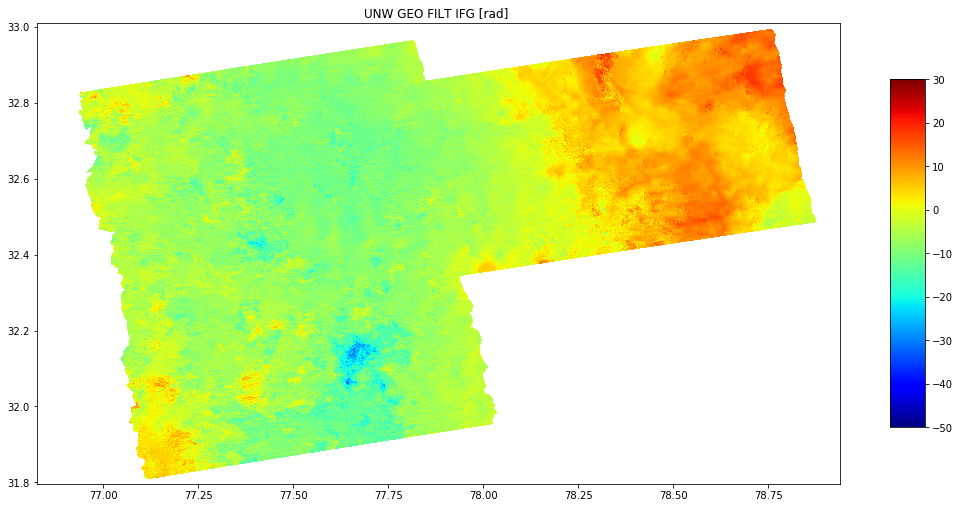

(1172, 2388)
9.0 45381.0 3.0 8207.0


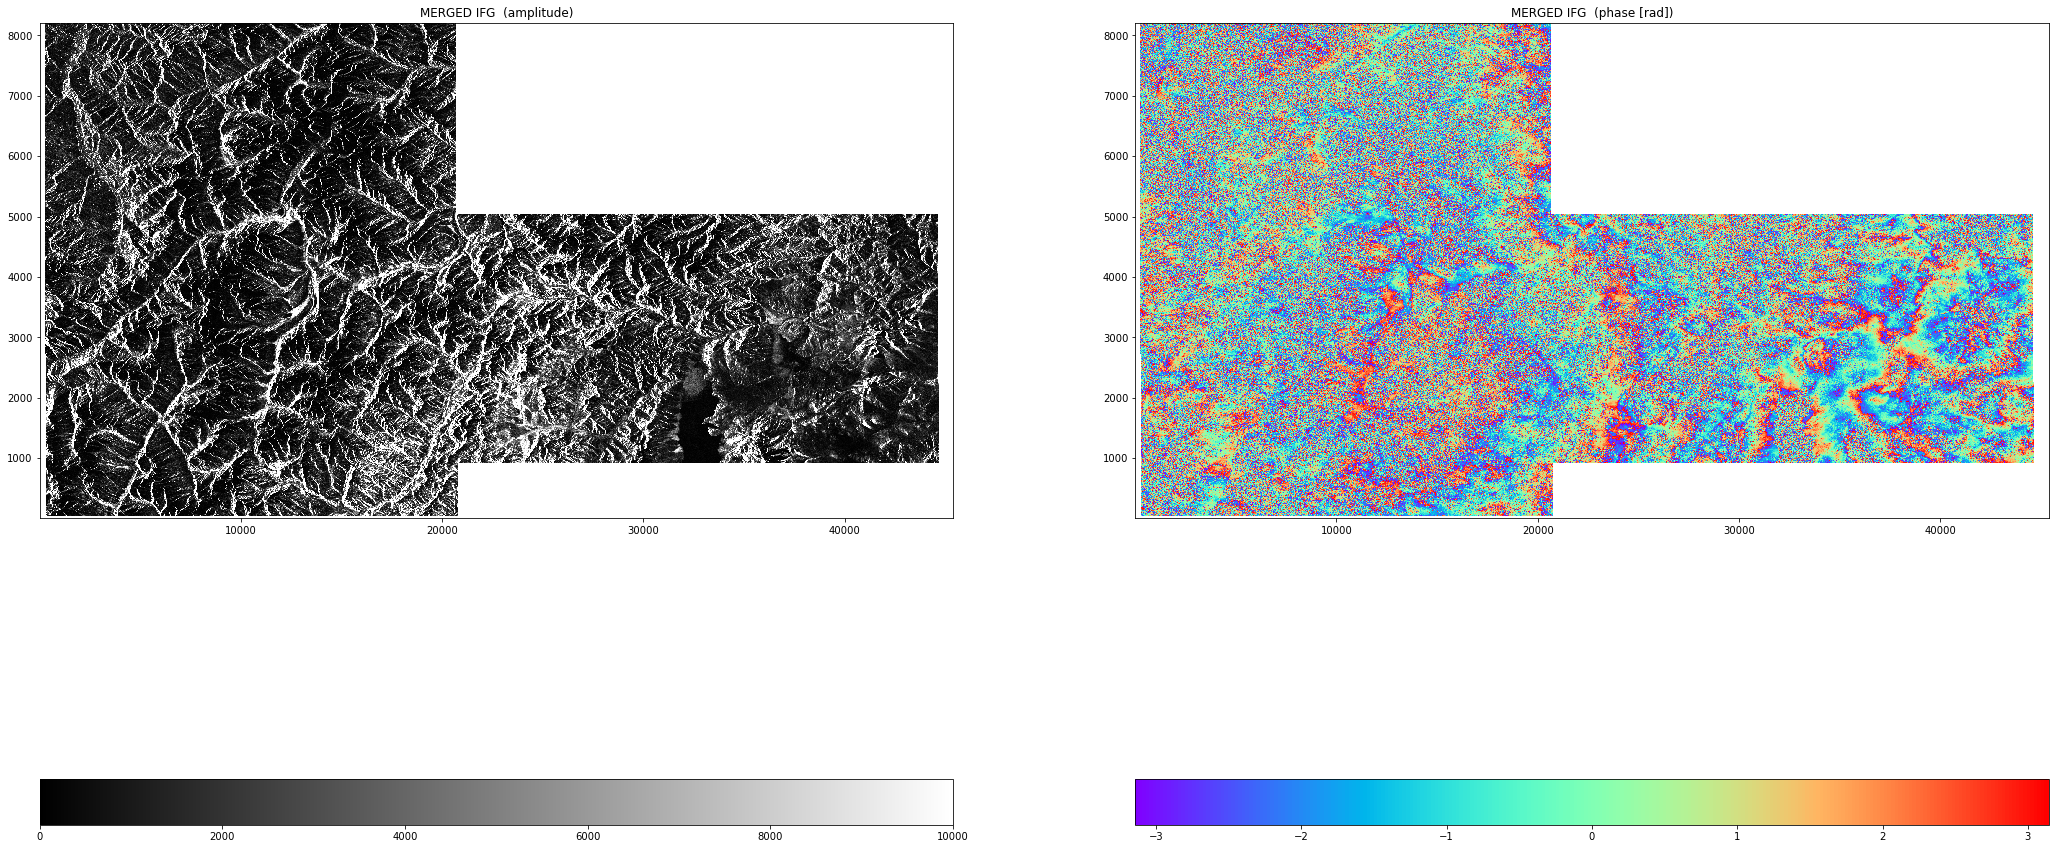

(1172, 2388)
0.0 2388.0 0.0 1172.0


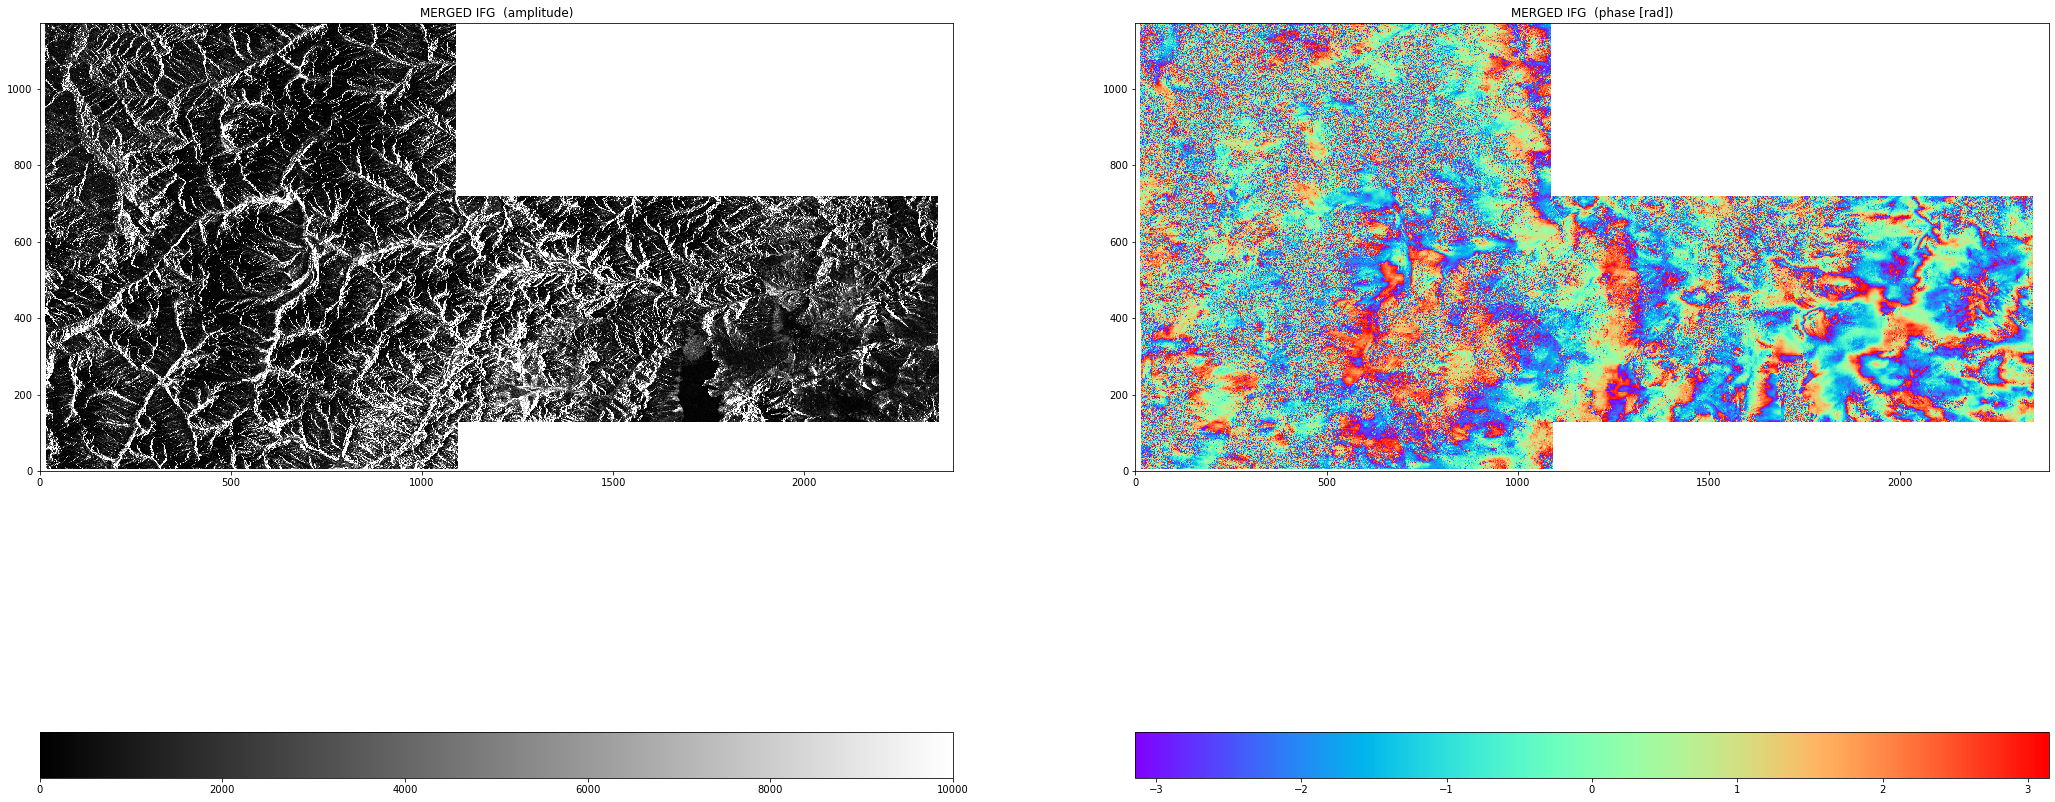

In [6]:
import glob
# plotcomplexdata('reference/IW3/burst_01.slc.vrt', 
#                 title="MERGED IFG ", aspect=1,
#                 datamin=0, datamax=10000, draw_colorbar=True)

#------topo----------
# plotdata('geom_reference/IW3/hgt_01.rdr', band=1,
#          title='IW3: Height of Burst 1 [meter]',
#          colormap='terrain')
# plotdata('geom_reference/IW3/los_01.rdr', band=1,
#          title='IW3: Incidence angle of Burst 1 [degrees]',
#          colormap='jet')
# plotdata('geom_reference/IW3/los_01.rdr', band=2,
#          title='IW3: Azimuth angle of Burst 1 [degrees]',
#          colormap='jet')

# plotdata('coarse_offsets/overlaps/IW3/azimuth_bot_01_02.off.vrt', band=1,
#          title='Azimuth bot_01_02', colormap='gray', aspect=10,
#          nodata=-999999.)
# !gdalinfo -stats coarse_offsets/overlaps/IW3/range_bot_01_02.off.vrt

#-------------------------
# plotcomplexdata('fine_interferogram/IW3/burst_01.3alks_7rlks.int.vrt', 
#                 title="Burst 3 IFG ", aspect=3, datamin=0, datamax=10000,
#                 draw_colorbar=True)
# plotstackcomplexdata('coarse_interferogram/overlaps/IW3/burst_top_*.3alks_7rlks.int',
#                      title="Top overlaps ", aspect=10, datamin=0, datamax=6000,
#                      draw_colorbar=True, colorbar_orientation="horizontal")

#-------- geocode --------
# plotdata('merged/filt_topophase.unw.geo', band=2,
#          title="UNW GEO FILT IFG [rad] ", colormap='jet',
#          colorbar_orientation="vertical", datamin=-20, datamax=50)

#-------unwrap-------
# plotdata('merged/filt_topophase.conncomp', band=1,
#          title="UNW CONN COMP [-] ", colormap='jet',
#          colorbar_orientation="vertical",
#          nodata=0)

plotdata('merged/filt_topophase.unw.geo', band=2,
         title="UNW GEO FILT IFG [rad] ", colormap='jet',
         colorbar_orientation="vertical", datamin=-50, datamax=30)

#-------filter-------
plotcomplexdata('merged/topophase.flat.vrt',
                title="MERGED IFG ", aspect=3,
                datamin=0, datamax=10000, draw_colorbar=True)

# plotdata('merged/topophase.cor', band=2,
#          title="MERGED COR ", aspect=3,
#          datamin=0, datamax=1, colorbar_orientation="vertical")

plotcomplexdata('merged/filt_topophase.flat.vrt',
                title="MERGED IFG ", aspect=1,
                datamin=0, datamax=10000, draw_colorbar=True)
# plotcomplexdata('merged/topophase.ion.vrt', 
#                 title="MERGED FILT IFG ", aspect=3,
#                 datamin=0, datamax=10000, draw_colorbar=True)
# plotcomplexdata('merged/topophase_ori.flat.vrt', 
#                 title="MERGED FILT IFG ", aspect=3,
#                 datamin=0, datamax=10000, draw_colorbar=True)
# (1874, 3587)


In [7]:
ls merged/

dem.crop                     lon.rdr.full.xml        topophase.cor.full.xml
dem.crop.vrt                 los.rdr                 topophase.cor.geo
dem.crop.xml                 los.rdr.full.vrt        topophase.cor.geo.vrt
filt_topophase.conncomp      los.rdr.full.xml        topophase.cor.geo.xml
filt_topophase.conncomp.vrt  los.rdr.geo             topophase.cor.vrt
filt_topophase.conncomp.xml  los.rdr.geo.vrt         topophase.cor.xml
filt_topophase.flat          los.rdr.geo.xml         topophase.flat
filt_topophase.flat.geo      los.rdr.vrt             topophase.flat.full.vrt
filt_topophase.flat.geo.vrt  los.rdr.xml             topophase.flat.full.xml
filt_topophase.flat.geo.xml  phsig.cor               topophase.flat.geo
filt_topophase.flat.vrt      phsig.cor.geo           topophase.flat.geo.vrt
filt_topophase.flat.xml      phsig.cor.geo.vrt       topophase.flat.geo.xml
filt_topophase.unw           phsig.cor.geo.xml       topophase.flat.vrt
filt_topophase.unw.geo       phsig.cor.vrt 

0.9284377 0.1428871 0.19785772 (4367, 7616)
76.82388888888889 78.93944444444445 31.79638888888889 33.00944444444445


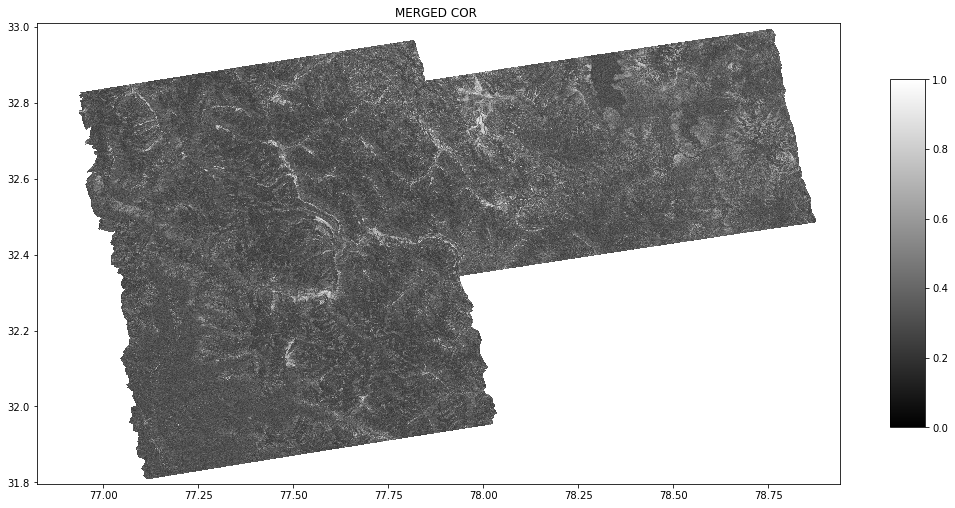

In [23]:
plotdata('merged/topophase.cor.geo', band=2,
         title="MERGED COR ", aspect=1,
         datamin=0, datamax=1, colorbar_orientation="vertical")

In [25]:
ds = gdal.Open('merged/topophase.cor.geo', gdal.GA_ReadOnly)
data = ds.GetRasterBand(2).ReadAsArray()
transform = ds.GetGeoTransform()
ds = None

In [34]:
data[data!=0].m()

0.9284377

In [5]:
%cd ../feb_pair1

/run/user/1000/gvfs/sftp:host=172.26.126.105/DATA/glacier-vel/feb_pair1


76.82222222222222 78.93833333333333 31.796666666666667 33.00972222222222
0.3671932 -1.9506192 -0.97994316


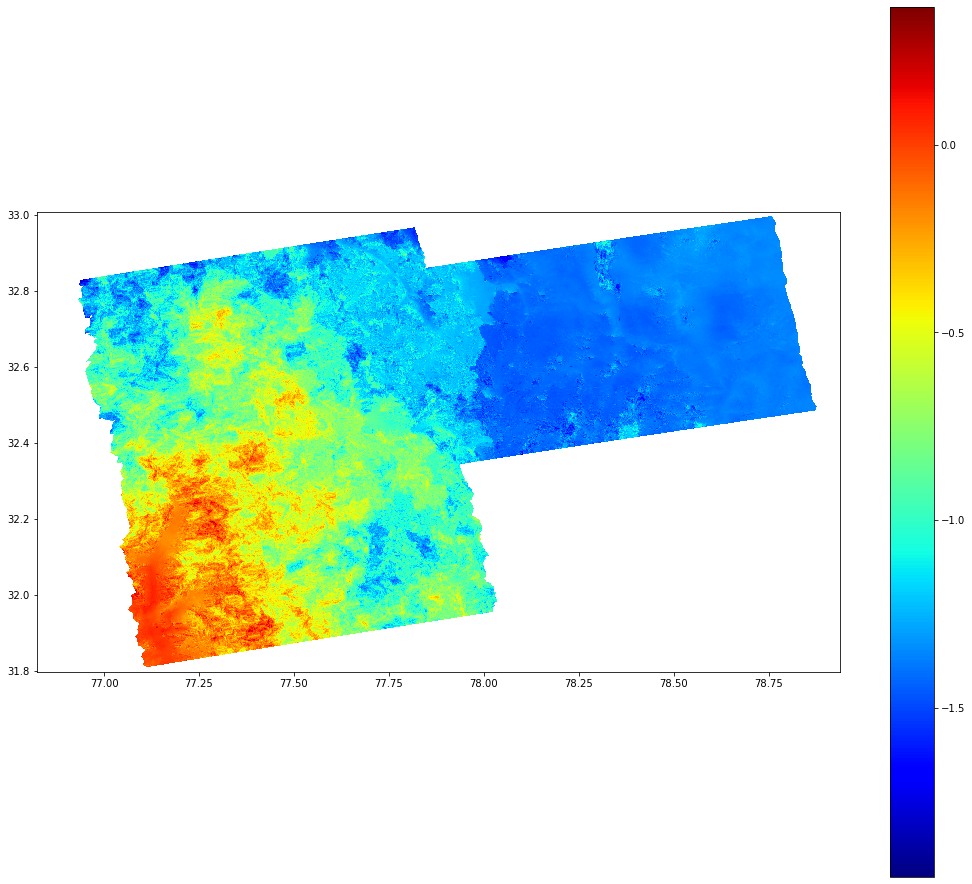

(76.82222222222222, 0.0002777777777777778, 0.0, 33.00972222222222, 0.0, -0.0002777777777777778)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]


In [6]:
ds = gdal.Open('merged/filt_topophase.unw.geo', gdal.GA_ReadOnly)
unw = ds.GetRasterBand(2).ReadAsArray()
transform = ds.GetGeoTransform()
projs = ds.GetProjection()
geo = ds.GetGeoTransform()
dr = (0.056*unw)/(4*np.pi)
dr = (dr/12)*100
dr[unw==0] = np.nan
firstx = transform[0]
firsty = transform[3]
deltay = transform[5]
deltax = transform[1]
lastx = firstx+dr.shape[1]*deltax
lasty = firsty+dr.shape[0]*deltay
ymin = np.min([lasty,firsty])
ymax = np.max([lasty,firsty])
xmin = np.min([lastx,firstx])
xmax = np.max([lastx,firstx])
print(xmin,xmax,ymin,ymax)
print(dr[unw!=0].max(), dr[unw!=0].min(), dr[unw!=0].mean())

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
# disp[incid==0] = np.nan vmin=-0.2, vmax=0.3,
cax = ax.imshow(dr,
                cmap='jet', extent=[xmin,xmax,ymin,ymax],
                interpolation='nearest')
# ax.set_title(title)
if True is not None:
    cbar = fig.colorbar(cax)
ax.set_aspect(1)    
plt.show()
dr[unw==0] = -32767
ds = numpy_array_to_raster("dinsar_disp.tif", dr, projs, geo)
# 0.70763046 -2.7005284 -0.9440788

# 0.28906992 -7.157085 -2.3064032

# 0.26217166 -2.313441 -0.93341076 snaphu

In [10]:
!gdalwarp -te 76.86 32.06 77.82 32.77 ./dinsar_disp.tif ./dinsar_disp_roi.tif

ERROR 4: `./dinsar_disp.tif' not recognized as a supported file format.


0.0 3587.0 0.0 1874.0


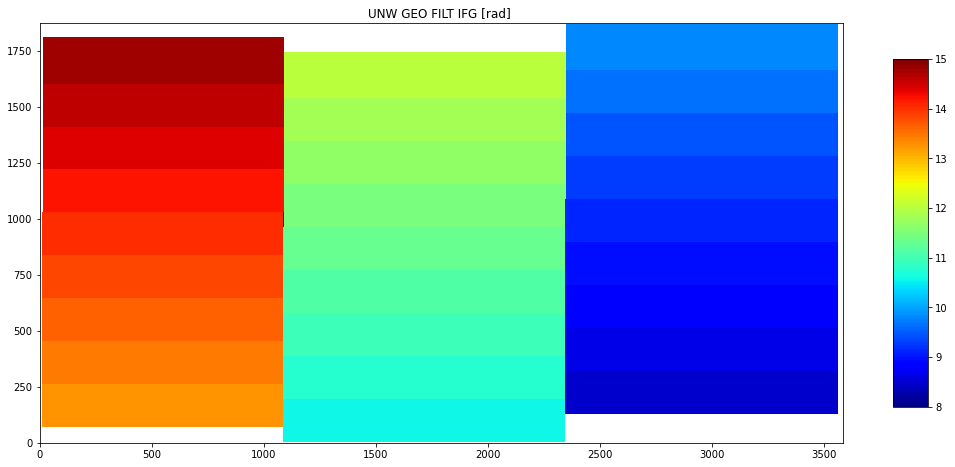

In [39]:
# (23 * 0.056)/ ( -4*np.pi*np.cos(deg2rad*35))r
import math
ds = gdal.Open('merged/filt_topophase.unw', gdal.GA_ReadOnly)
data = ds.GetRasterBand(2).ReadAsArray()
# Swath 1
data[math.floor(442/7):math.floor(1890/7),math.floor(229/19):math.floor(20653/19)] = 14.78811289199332
data[math.floor(1891/7):math.floor(3234/7),math.floor(229/19):math.floor(20653/19)] = 14.597183819623305
data[math.floor(3234/7):math.floor(4571/7),math.floor(229/19):math.floor(20653/19)] = 14.406238278544386
data[math.floor(4571/7):math.floor(5915/7),math.floor(229/19):math.floor(20653/19)] = 14.21522258946101
data[math.floor(5915/7):math.floor(7259/7),math.floor(172/19):math.floor(20596/19)] = 14.024152183314705
data[math.floor(7259/7):math.floor(8596/7),math.floor(172/19):math.floor(20596/19)] = 13.833008595403507
data[math.floor(8596/7):math.floor(9940/7),math.floor(172/19):math.floor(20596/19)] = 13.641577787523087
data[math.floor(9940/7):math.floor(11284/7),math.floor(172/19):math.floor(20596/19)] = 13.450036330993353
data[math.floor(11284/7):math.floor(12628/7),math.floor(172/19):math.floor(20596/19)] = 13.258750859325138

# Swath 2
data[math.floor(911/7):math.floor(2352/7),math.floor(20654/19):math.floor(44593/19)] = 12.029214924638662
data[math.floor(2353/7):math.floor(3696/7),math.floor(20654/19):math.floor(44593/19)] = 11.850459266661279
data[math.floor(3697/7):math.floor(5040/7),math.floor(20654/19):math.floor(44593/19)] = 11.671841193761736
data[math.floor(5041/7):math.floor(6377/7),math.floor(20654/19):math.floor(44593/19)] = 11.49298548797845
data[math.floor(6378/7):math.floor(7721/7),math.floor(20597/19):math.floor(44536/19)] = 11.313970198850756
data[math.floor(7722/7):math.floor(9059/7),math.floor(20597/19):math.floor(44536/19)] = 11.134952385499165
data[math.floor(9059/7):math.floor(10403/7),math.floor(20597/19):math.floor(44536/19)] = 10.956071259482561
data[math.floor(10403/7):math.floor(11747/7),math.floor(20597/19):math.floor(44536/19)] = 10.77677652641249
data[math.floor(11747/7):math.floor(13090/7),math.floor(20597/19):math.floor(44536/19)] = 10.59764356048525

# Swath 3
data[math.floor(29/7):math.floor(1477/7),math.floor(44594/19):math.floor(67678/19)] = 9.808163009266726
data[math.floor(1478/7):math.floor(2821/7),math.floor(44594/19):math.floor(67678/19)] = 9.640802825518476
data[math.floor(2822/7):math.floor(4165/7),math.floor(44594/19):math.floor(67678/19)] = 9.473201395961869
data[math.floor(4166/7):math.floor(5502/7),math.floor(44594/19):math.floor(67678/19)] = 9.305478183605784
data[math.floor(5503/7):math.floor(6846/7),math.floor(44537/19):math.floor(67678/19)] = 9.1378656301824
data[math.floor(6847/7):math.floor(8190/7),math.floor(44537/19):math.floor(67640/19)] = 8.969917137181298
data[math.floor(8191/7):math.floor(9527/7),math.floor(44537/19):math.floor(67640/19)] = 8.802384890076665
data[math.floor(9528/7):math.floor(10871/7),math.floor(44537/19):math.floor(67640/19)] = 8.63458125803577
data[math.floor(10872/7):math.floor(12208/7),math.floor(44537/19):math.floor(67640/19)] = 8.466622776736477



transform = ds.GetGeoTransform()
ds = None

try:
    if nodata is not None:
        data[data == nodata] = np.nan
except:
    pass

# getting the min max of the axes
datamin = 8
datamax = 15
colorbar_orientation="vertical"
colormap='jet'
title="UNW GEO FILT IFG [rad] "

firstx = transform[0]
firsty = transform[3]
deltay = transform[5]
deltax = transform[1]
lastx = firstx+data.shape[1]*deltax
lasty = firsty+data.shape[0]*deltay
ymin = np.min([lasty,firsty])
ymax = np.max([lasty,firsty])
xmin = np.min([lastx,firstx])
xmax = np.max([lastx,firstx])

print(xmin,xmax,ymin,ymax)
# put all zero values to nan and do not plot nan
# if background is None:
try:
    data[data==0]=np.nan
except:
    pass

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
cax = ax.imshow(data, vmin = datamin, vmax=datamax,
                cmap=colormap, extent=[xmin,xmax,ymin,ymax],
                interpolation='nearest')
ax.set_title(title)
# if draw_colorbar is not None:
cbar = fig.colorbar(cax,orientation=colorbar_orientation, shrink=.4, pad=.05, aspect=10)
# ax.set_aspect(aspect)    
plt.show()

# clearing the data
# data = None

In [46]:
np.save('perp_baseline.npy', data)
data.shape

(1874, 3587)

In [79]:
phase[math.floor(442/7):math.floor(1890/7),math.floor(229/19):math.floor(20653/19)].min()

0.07812285890206234

In [78]:
ds = gdal.Open('merged/z.rdr', gdal.GA_ReadOnly)
z = ds.GetRasterBand(1).ReadAsArray()
hgt = 693000-z
q = z + 20
incid_ds = gdal.Open('merged/los.rdr', gdal.GA_ReadOnly)
incid = incid_ds.GetRasterBand(1).ReadAsArray()
# tan = np.tan
deg2rad = np.pi/180
transform = incid_ds.GetGeoTransform()
perp = data.copy()
print(perp.shape, q.shape, hgt.shape, incid.shape)
phase = (4*np.pi*perp*q)/(hgt*np.tan(incid*deg2rad)*0.056)
# incid.max()

(1874, 3587) (1874, 3587) (1874, 3587) (1874, 3587)


68162.0


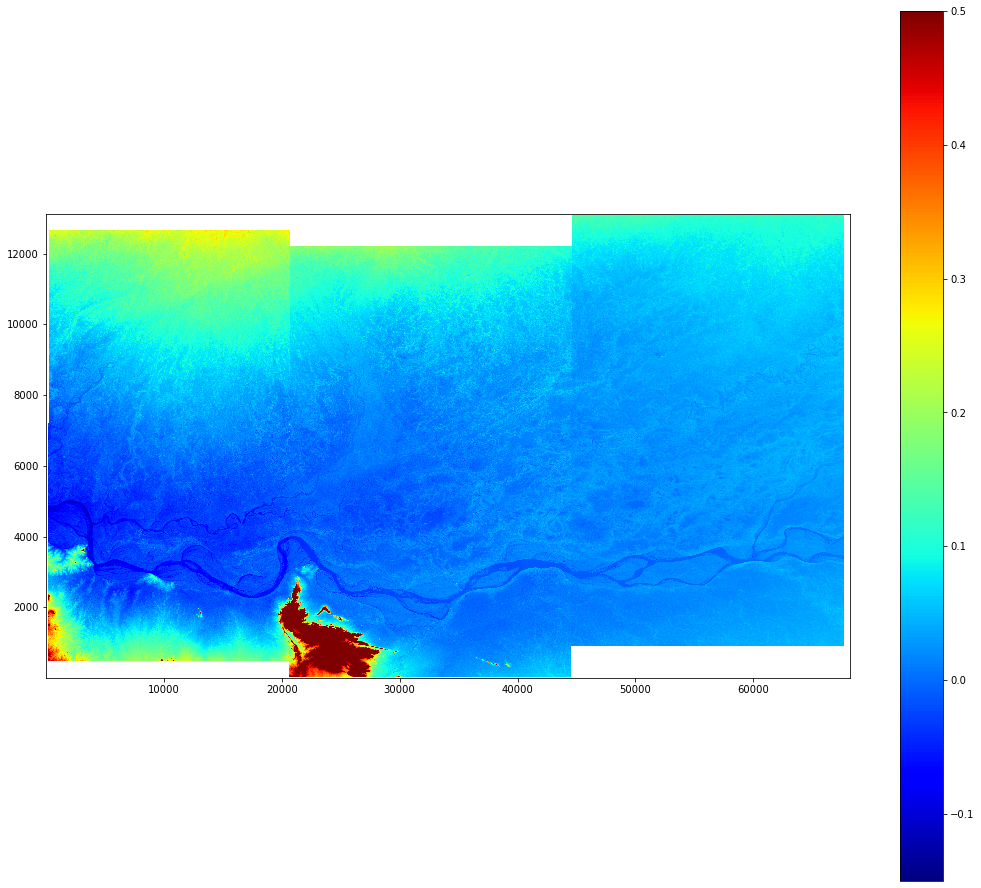

In [85]:
# disp.shape

firstx = transform[0]
firsty = transform[3]
deltay = transform[5]
deltax = transform[1]
lastx = firstx+phase.shape[1]*deltax
lasty = firsty+phase.shape[0]*deltay
ymin = np.min([lasty,firsty])
ymax = np.max([lasty,firsty])
xmin = np.min([lastx,firstx])
xmax = np.max([lastx,firstx])

print(xmax)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
# phase[incid==0] = np.nan
cax = ax.imshow(phase,vmin=-0.15, vmax=0.5,
                cmap='jet', extent=[xmin,xmax,ymin,ymax],
                interpolation='nearest')
# ax.set_title(title)
if True is not None:
    cbar = fig.colorbar(cax)
ax.set_aspect(3)    
plt.show()


In [63]:
# ds = gdal.Open('merged/dem.crop', gdal.GA_ReadOnly)
# dem = ds.GetRasterBand(1).ReadAsArray()
# dem.min()
np.percentile(z, 10)


-21.982545590388476

In [182]:
print(disp.min(), disp.max(), disp.mean() , disp.std())
# incid.max()
# mask_nd = (incid==0)
# from scipy import interpolate
# unw1= np.load('non_disp_1.npy')
# mymin,mymax = -100,100
# X = np.linspace(mymin,mymax,unw1.shape[1])
# Y = np.linspace(mymin,mymax,unw1.shape[0])
# x,y = np.meshgrid(X,Y)
# f = interpolate.interp2d(x,y,unw1,kind='cubic')

# Xnew = np.linspace(mymin,mymax,incid.shape[1])
# Ynew = np.linspace(mymin,mymax,incid.shape[0])
# test8x8 = f(Xnew,Ynew)
# unw.min()
# unw1.shape

-0.55673635 0.33017486 -0.021537464 0.12535962


In [20]:
ds = gdal.Open('merged/filt_topophase.unw.geo', gdal.GA_ReadOnly)
# mask_nd = (ds==0)
# projs = ds.GetProjection()
# geo = ds.GetGeoTransform()
# transform = ds.GetGeoTransform()
unw = ds.GetRasterBand(2).ReadAsArray()
incid_ds = gdal.Open('merged/los.rdr.geo', gdal.GA_ReadOnly)
projs = incid_ds.GetProjection()
geo = incid_ds.GetGeoTransform()
transform = incid_ds.GetGeoTransform()
incid = incid_ds.GetRasterBand(1).ReadAsArray()
# mask_nd = (incid==0)
print(unw.shape, incid.shape)
deg2rad = np.pi/180
disp = (unw * 0.056)/ ( -4*np.pi*np.cos(incid*deg2rad)) ###
# disp_fl = disp[not mask_nd]

(7191, 10387) (7191, 10387)


In [8]:
# np.cos(incid.max())
# (unw<0)
disp_fl = disp[not mask_nd]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [131]:
output_path = 'disp.tif'
ds = numpy_array_to_raster(output_path, disp, projs, geo)
ds.FlushCache()
ds = None

(84.77916666666667, 0.0002777777777777778, 0.0, 26.889444444444443, 0.0, -0.0002777777777777778)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]


87.66444444444444


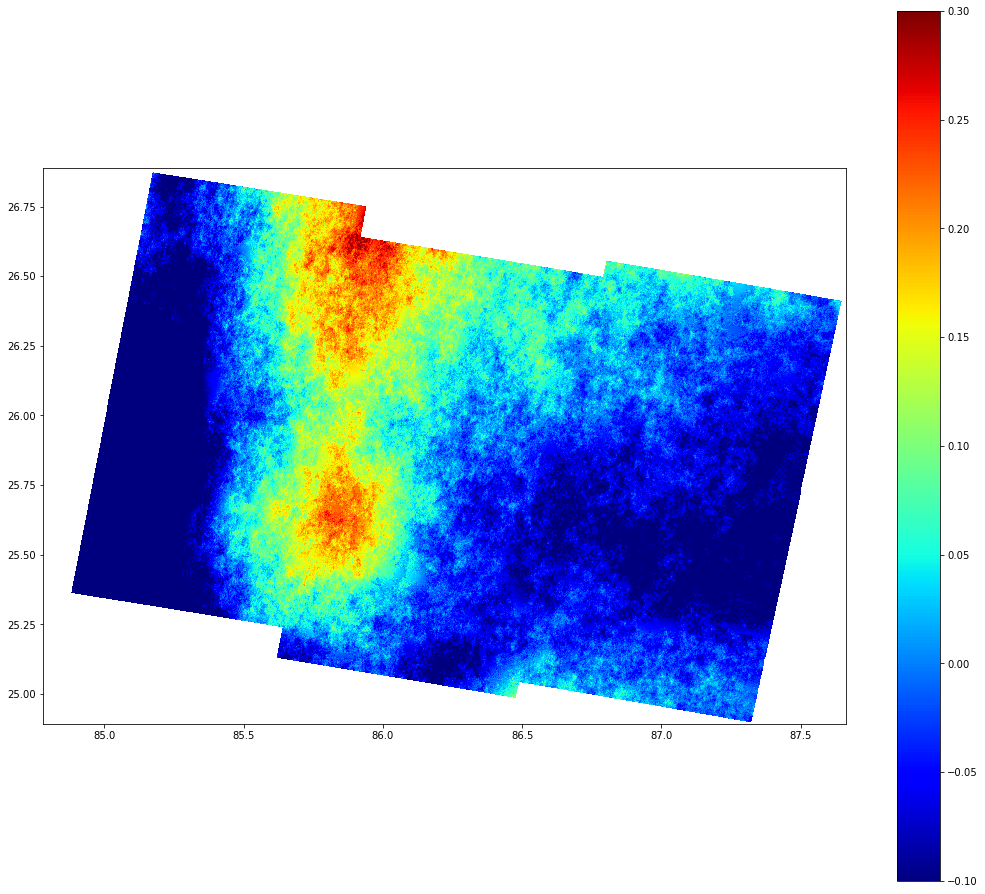

In [21]:
# disp.shape

firstx = transform[0]
firsty = transform[3]
deltay = transform[5]
deltax = transform[1]
lastx = firstx+disp.shape[1]*deltax
lasty = firsty+disp.shape[0]*deltay
ymin = np.min([lasty,firsty])
ymax = np.max([lasty,firsty])
xmin = np.min([lastx,firstx])
xmax = np.max([lastx,firstx])

print(xmax)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
disp[incid==0] = np.nan
cax = ax.imshow(disp,vmin=-0.2, vmax=0.3,
                cmap='jet', extent=[xmin,xmax,ymin,ymax],
                interpolation='nearest')
# ax.set_title(title)
if True is not None:
    cbar = fig.colorbar(cax)
ax.set_aspect(1)    
plt.show()

(18460922,) -7.157085 0.28906992


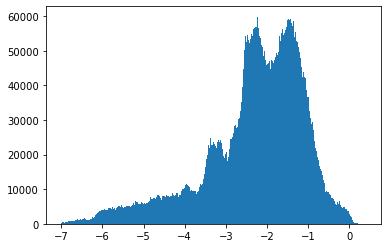

In [12]:
data = dr[unw!=0].copy()
print(data.shape, data.min(), data.max())

plt.hist(data, bins=1000, range=[-7,0.4])
plt.show()

In [117]:
pip install pandas

     |████████████████████████████████| 11.7 MB 3.2 MB/s eta 0:00:01    |█████████████████████           | 7.7 MB 3.2 MB/s eta 0:00:02
  Using cached pytz-2022.2.1-py2.py3-none-any.whl (500 kB)
Note: you may need to restart the kernel to use updated packages.


In [126]:
import pandas as pd
df = pd.read_csv('/DATA/glacier-vel/Automated_Offset_Tracking/data/data_download1.csv')
df19 = df[110:122].copy()

In [138]:
df192 = df[111:122].copy()
df192

Unnamed: 0  Start Date  \
111         111  2019-06-02   
112         112  2019-06-14   
113         113  2019-06-26   
114         114  2019-07-08   
115         115  2019-07-20   
116         116  2019-08-01   
117         117  2019-08-13   
118         118  2019-08-25   
119         119  2019-09-06   
120         120  2019-09-18   
121         121  2019-09-30   

                                                Master  \
111  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
112  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
113  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
114  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
115  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
116  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
117  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
118  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
119  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
120  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
121  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   

                                                 Slave  Status  \
111  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
112  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
113  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
114  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
115  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
116  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
117  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
118  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
119  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
120  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   
121  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     0.0   

                              ROI  
111  [32.06, 32.77, 76.86, 77.82]  
112  [32.06, 32.77, 76.86, 77.82]  
113  [32.06, 32.77, 76.86, 77.82]  
114  [32.06, 32.77, 76.86, 77.82]  
115  [32.06, 32.77, 76.86, 77.82]  
116  [32.06, 32.77, 76.86, 77.82]  
117  [32.06, 32.77, 76.86, 77.82]  
118  [32.06, 32.77, 76.86, 77.82]  
119  [32.06, 32.77, 76.86, 77.82]  
120  [32.06, 32.77, 76.86, 77.82]  
121  [32.06, 32.77, 76.86, 77.82]

In [148]:
master = df19['Master'].tolist()[0]
df19['Master'] = master
masters = df19['Master'].tolist()
slaves = df19['Slave'].tolist()
dates = df19['Start Date'].tolist()
dates = [date+'_2' for date in dates]
masters += df192['Master'].tolist()
slaves += df192['Slave'].tolist()
dates += df192['Start Date'].tolist()
# len(df19['Master'].tolist())
dates

['2019-05-21_2',
 '2019-06-02_2',
 '2019-06-14_2',
 '2019-06-26_2',
 '2019-07-08_2',
 '2019-07-20_2',
 '2019-08-01_2',
 '2019-08-13_2',
 '2019-08-25_2',
 '2019-09-06_2',
 '2019-09-18_2',
 '2019-09-30_2',
 '2019-06-02',
 '2019-06-14',
 '2019-06-26',
 '2019-07-08',
 '2019-07-20',
 '2019-08-01',
 '2019-08-13',
 '2019-08-25',
 '2019-09-06',
 '2019-09-18',
 '2019-09-30']

In [153]:
df2 = pd.DataFrame({'Start Date': dates, 'Master': masters, 'Slave': slaves, 'Status':[0]*len(dates), 'ROI':["[32.06, 32.77, 76.86, 77.82]"]*len(dates)})
df2

Start Date                                             Master  \
0   2019-05-21_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
1   2019-06-02_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
2   2019-06-14_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
3   2019-06-26_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
4   2019-07-08_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
5   2019-07-20_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
6   2019-08-01_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
7   2019-08-13_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
8   2019-08-25_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
9   2019-09-06_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
10  2019-09-18_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
11  2019-09-30_2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
12    2019-06-02  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
13    2019-06-14  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
14    2019-06-26  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
15    2019-07-08  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
16    2019-07-20  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
17    2019-08-01  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
18    2019-08-13  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
19    2019-08-25  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
20    2019-09-06  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
21    2019-09-18  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   
22    2019-09-30  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...   

                                                Slave  Status  \
0   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
1   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
2   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
3   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
4   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
5   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
6   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
7   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
8   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
9   https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
10  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
11  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
12  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
13  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
14  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
15  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
16  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
17  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
18  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
19  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
20  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
21  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   
22  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...       0   

                             ROI  
0   [32.06, 32.77, 76.86, 77.82]  
1   [32.06, 32.77, 76.86, 77.82]  
2   [32.06, 32.77, 76.86, 77.82]  
3   [32.06, 32.77, 76.86, 77.82]  
4   [32.06, 32.77, 76.86, 77.82]  
5   [32.06, 32.77, 76.86, 77.82]  
6   [32.06, 32.77, 76.86, 77.82]  
7   [32.06, 32.77, 76.86, 77.82]  
8   [32.06, 32.77, 76.86, 77.82]  
9   [32.06, 32.77, 76.86, 77.82]  
10  [32.06, 32.77, 76.86, 77.82]  
11  [32.06, 32.77, 76.86, 77.82]  
12  [32.06, 32.77, 76.86, 77.82]  
13  [32.06, 32.77, 76.86, 77.82]  
14  [32.06, 32.77, 76.86, 77.82]  
15  [32.06, 32.77, 76.86, 77.82]  
16  [32.06, 32.77, 76.86, 77.82]  
17  [32.06, 32.77, 76.86, 77.82]  
18  [32.06, 32.77, 76.86, 77.82]  
19  [32.06, 32.77, 76.86, 77.82]  
20  [

In [154]:
df2.to_csv('/DATA/glacier-vel/Automated_Offset_Tracking/data/data_test.csv')

In [115]:
ls /DATA/glacier-vel/Automated_Offset_Tracking/data/data_download1.csv

/DATA/glacier-vel/Automated_Offset_Tracking/data/data_download1.csv
